In [1]:
import numpy as np
import requests, json
import pandas as pd


dados_json = requests.get("https://data.cms.gov/data-api/v1/dataset/939226be-b107-476e-8777-f199a840138a/data")
dados_dict = dados_json.json()
df = pd.DataFrame(dados_dict)

print("DataFrame loaded. Initial shape:", df.shape)
print("Initial DataFrame Info:")
df.info()


numerical_cols = [
    'Year',
    'Total_Bene_TH_Elig',
    'Total_PartB_Enrl',
    'Total_Bene_Telehealth',
    'Pct_Telehealth'
]


for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\nDataFrame after initial numerical column conversion. Info:")
df.info()


demographic_cols = [
    'Bene_Mdcd_Mdcr_Enrl_Stus',
    'Bene_Race_Desc',
    'Bene_Sex_Desc',
    'Bene_Age_Desc'
]

initial_rows_before_filters = df.shape[0]


df = df[~df['Bene_Geo_Desc'].isin(['National', 'Territories', 'Missing Data'])].copy()
print(f"\nFiltered Bene_Geo_Desc: {initial_rows_before_filters - df.shape[0]} rows removed. New shape: {df.shape}")


initial_rows_before_demographic_filter = df.shape[0]
all_demographics_are_all_mask = (df[demographic_cols] == 'All').all(axis=1)
df = df[~all_demographics_are_all_mask].copy()
print(f"Filtered rows where all demographic columns are 'All': {initial_rows_before_demographic_filter - df.shape[0]} rows removed. New shape: {df.shape}")


if not df.empty:
    quarter_unique_values = df['quarter'].unique()
    if 'Overall' in quarter_unique_values and len(quarter_unique_values) > 1:
        initial_rows_quarter_filter = df.shape[0]
        df = df[df['quarter'] != 'Overall'].copy()
        print(f"Filtered quarter 'Overall' (conditionally): {initial_rows_quarter_filter - df.shape[0]} rows removed. New shape: {df.shape}")
    elif 'Overall' in quarter_unique_values and len(quarter_unique_values) == 1:
        print(f"Skipping filter for quarter 'Overall' as it's the only quarter value, to prevent empty DataFrame. Current shape: {df.shape}")
else:
    print(f"DataFrame is empty before quarter filter. Current shape: {df.shape}")


if df.empty:
    print("\nWarning: DataFrame is empty after filtering steps. Cannot proceed with NaN dropping.")
else:

    initial_rows_before_dropna = df.shape[0]
    df.dropna(subset=['Pct_Telehealth'], inplace=True)
    print(f"\nDropped NaN values in 'Pct_Telehealth': {initial_rows_before_dropna - df.shape[0]} rows removed. New shape: {df.shape}")


print("\nFinal Cleaned DataFrame Head:")
print(df.head())
print("\nFinal Cleaned DataFrame Info:")
df.info()


DataFrame loaded. Initial shape: (1000, 13)
Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Year                      1000 non-null   object
 1   quarter                   1000 non-null   object
 2   Bene_Geo_Desc             1000 non-null   object
 3   Bene_Mdcd_Mdcr_Enrl_Stus  1000 non-null   object
 4   Bene_Race_Desc            1000 non-null   object
 5   Bene_Sex_Desc             1000 non-null   object
 6   Bene_Mdcr_Entlmt_Stus     1000 non-null   object
 7   Bene_Age_Desc             1000 non-null   object
 8   Bene_RUCA_Desc            1000 non-null   object
 9   Total_Bene_TH_Elig        1000 non-null   object
 10  Total_PartB_Enrl          1000 non-null   object
 11  Total_Bene_Telehealth     1000 non-null   object
 12  Pct_Telehealth            1000 non-null   object
dtypes: object(1

In [2]:
df['High_Adoption_Threshold'] = df.groupby(['Year', 'quarter'])['Pct_Telehealth'].transform(lambda x: x.quantile(0.75))
df['High_Adoption'] = (df['Pct_Telehealth'] >= df['High_Adoption_Threshold']).astype(int)

print("Distribution of 'High_Adoption' column:")
print(df['High_Adoption'].value_counts())

print("\nDataFrame head with new 'High_Adoption' column:")
print(df.head())

Distribution of 'High_Adoption' column:
High_Adoption
0    381
1    128
Name: count, dtype: int64

DataFrame head with new 'High_Adoption' column:
     Year  quarter Bene_Geo_Desc Bene_Mdcd_Mdcr_Enrl_Stus Bene_Race_Desc  \
337  2020  Overall       Alabama                      All            All   
338  2020  Overall        Alaska                      All            All   
339  2020  Overall       Arizona                      All            All   
340  2020  Overall      Arkansas                      All            All   
341  2020  Overall    California                      All            All   

    Bene_Sex_Desc Bene_Mdcr_Entlmt_Stus Bene_Age_Desc Bene_RUCA_Desc  \
337           All                   All          0-64            All   
338           All                   All          0-64            All   
339           All                   All          0-64            All   
340           All                   All          0-64            All   
341           All                   

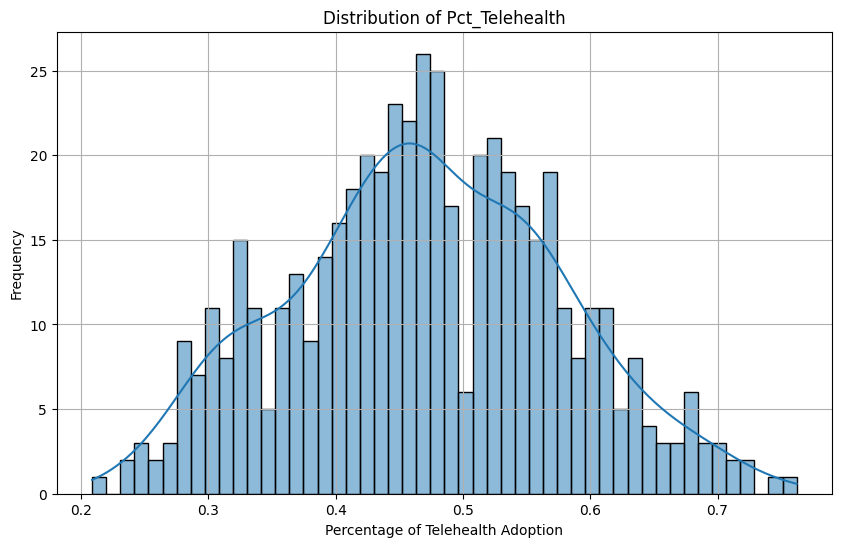

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['Pct_Telehealth'], bins=50, kde=True)
plt.title('Distribution of Pct_Telehealth')
plt.xlabel('Percentage of Telehealth Adoption')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Value counts for 'High_Adoption' column:
High_Adoption
0    381
1    128
Name: count, dtype: int64


C:\Users\Gustavo\AppData\Local\Temp\ipykernel_14196\1110036706.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='High_Adoption', data=df, palette='viridis')


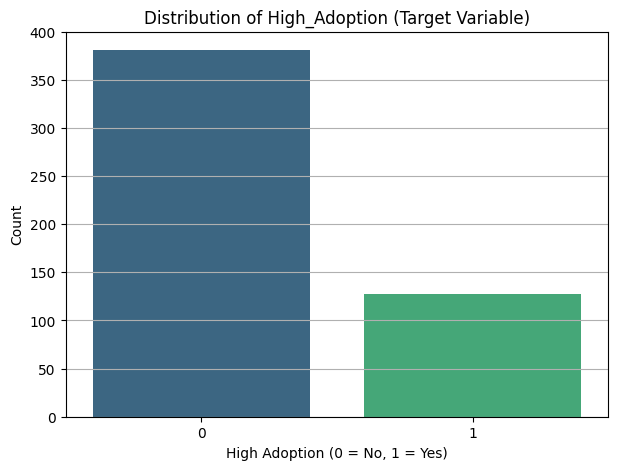

In [4]:
print("Value counts for 'High_Adoption' column:")
print(df['High_Adoption'].value_counts())

plt.figure(figsize=(7, 5))
sns.countplot(x='High_Adoption', data=df, palette='viridis')
plt.title('Distribution of High_Adoption (Target Variable)')
plt.xlabel('High Adoption (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

Value counts for 'High_Adoption' column:
High_Adoption
0    381
1    128
Name: count, dtype: int64


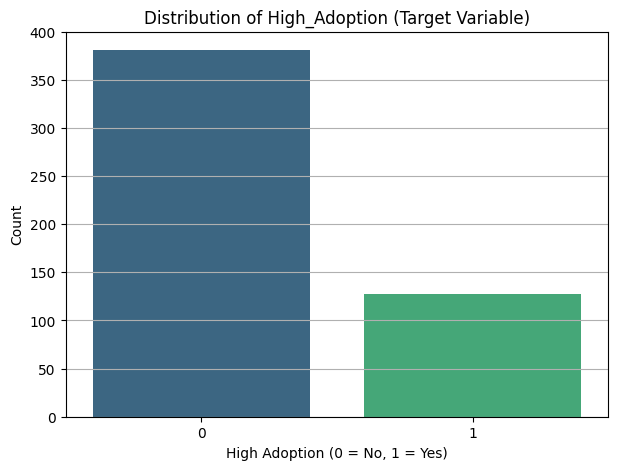

In [5]:
print("Value counts for 'High_Adoption' column:")
print(df['High_Adoption'].value_counts())

plt.figure(figsize=(7, 5))
sns.countplot(x='High_Adoption', data=df, palette='viridis', hue='High_Adoption', legend=False)
plt.title('Distribution of High_Adoption (Target Variable)')
plt.xlabel('High Adoption (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

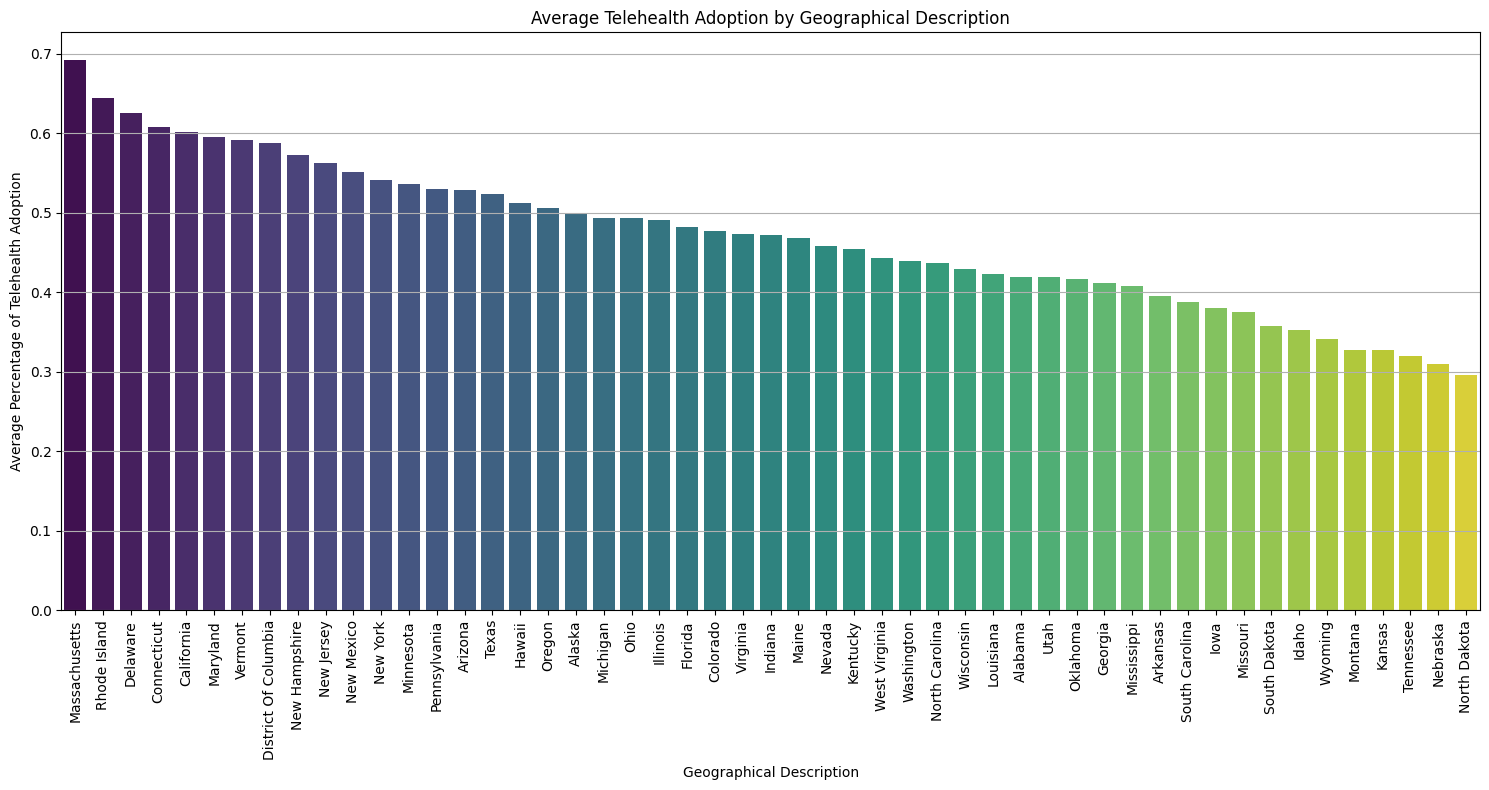

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Group by Bene_Geo_Desc and calculate the mean of Pct_Telehealth
geo_adoption = df.groupby('Bene_Geo_Desc')['Pct_Telehealth'].mean().reset_index()

# 2. Sort by Pct_Telehealth in descending order
geo_adoption = geo_adoption.sort_values(by='Pct_Telehealth', ascending=False)

# 3. Create a bar plot
plt.figure(figsize=(15, 8))
sns.barplot(x='Bene_Geo_Desc', y='Pct_Telehealth', data=geo_adoption, palette='viridis', hue='Bene_Geo_Desc', legend=False)
plt.title('Average Telehealth Adoption by Geographical Description')
plt.xlabel('Geographical Description')
plt.ylabel('Average Percentage of Telehealth Adoption')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

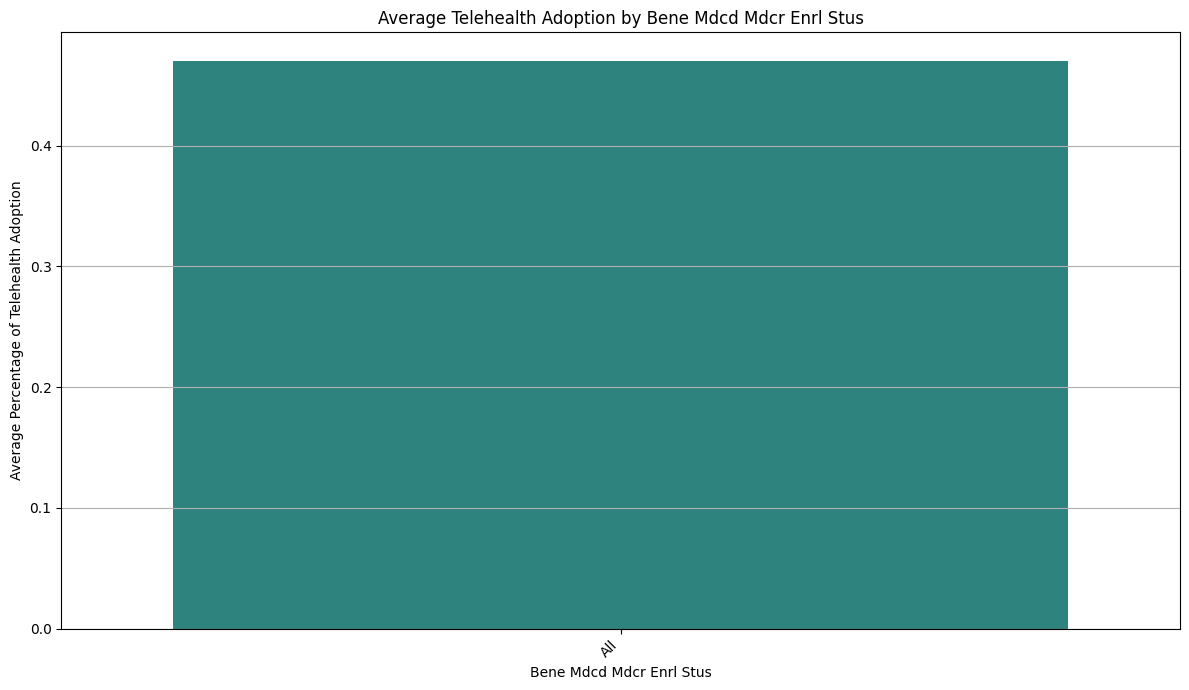

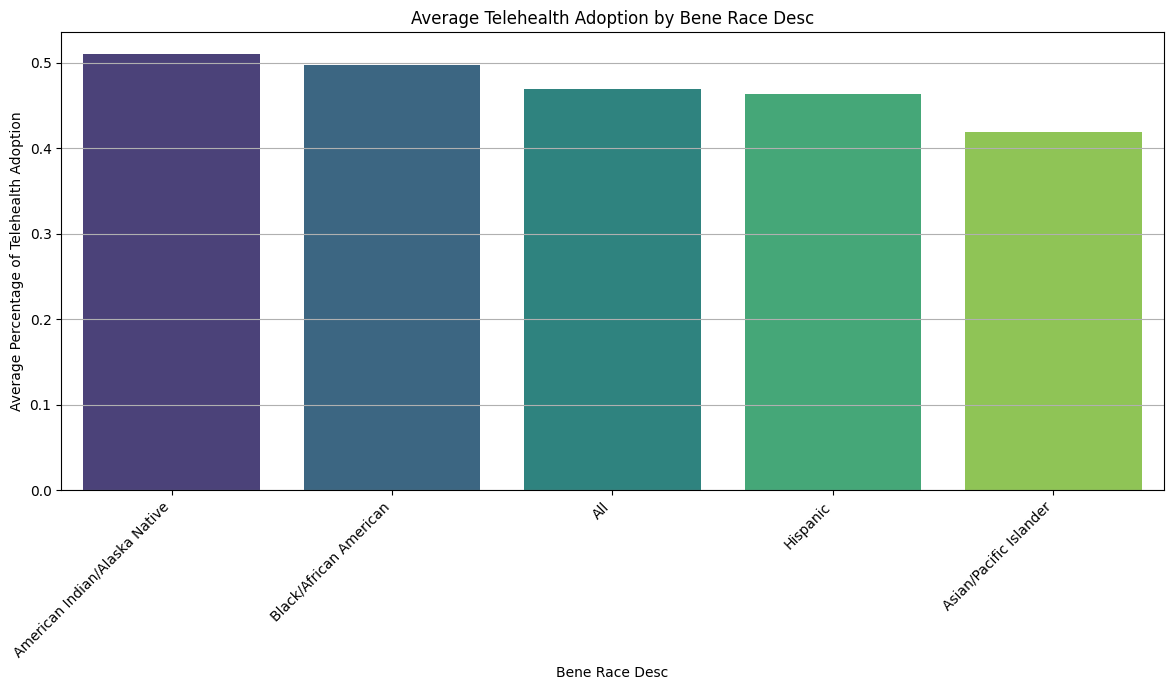

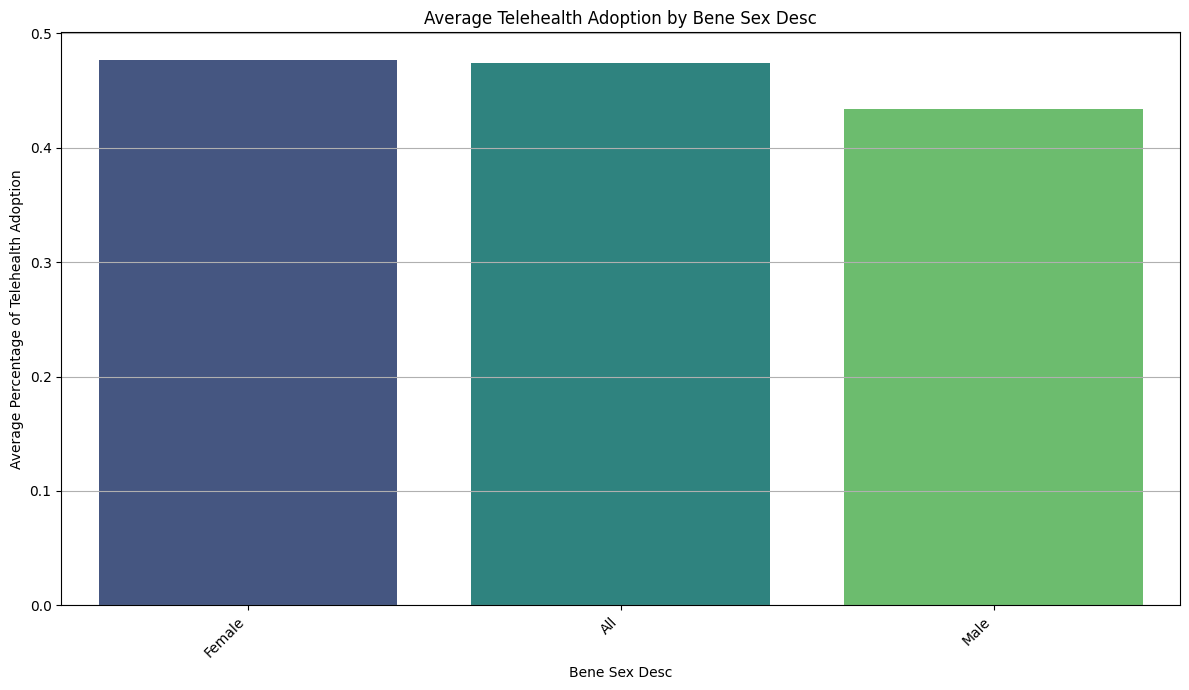

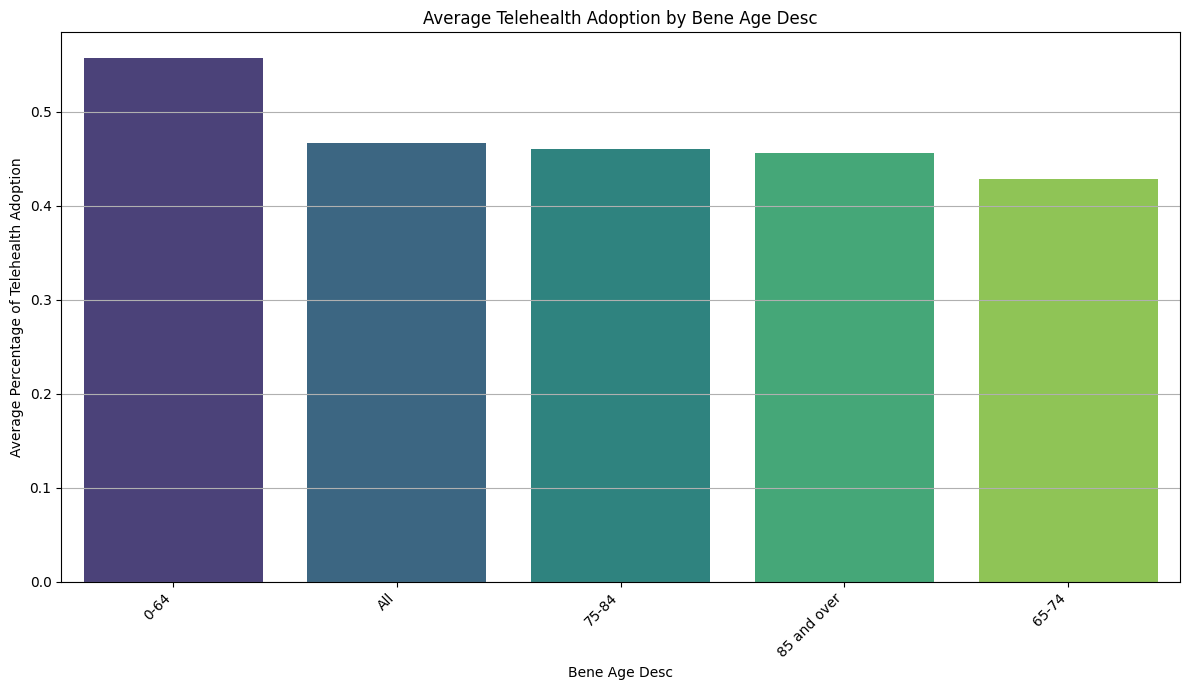

In [7]:
demographic_cols_to_visualize = [
    'Bene_Mdcd_Mdcr_Enrl_Stus',
    'Bene_Race_Desc',
    'Bene_Sex_Desc',
    'Bene_Age_Desc'
]

for col in demographic_cols_to_visualize:
    # Group by the current demographic column and calculate the mean of Pct_Telehealth
    demographic_adoption = df.groupby(col)['Pct_Telehealth'].mean().reset_index()

    # Sort by Pct_Telehealth in descending order
    demographic_adoption = demographic_adoption.sort_values(by='Pct_Telehealth', ascending=False)

    # Create a bar plot
    plt.figure(figsize=(12, 7))
    sns.barplot(x=col, y='Pct_Telehealth', data=demographic_adoption, palette='viridis', hue=col, legend=False)
    plt.title(f'Average Telehealth Adoption by {col.replace("_", " ")}')
    plt.xlabel(col.replace("_", " "))
    plt.ylabel('Average Percentage of Telehealth Adoption')
    plt.xticks(rotation=45, ha='right') # Rotate for better readability
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

1) É possível prever se uma combinação de características regionais e demográficas leva uma região (estado/trimestre) a estar entre os grupos de alta adoção de telemedicina?



Principais Insights:

Adoção: A adoção da telemedicina mostrou uma tendência crescente, com um aumento acentuado em 2020.
Variação Geográfica: Há variações significativas na adoção entre estados, como Texas e Geórgia com taxas mais altas.
Influência Demográfica: Grupos demográficos como 'Não Inscritos' no Medicare/Medicaid, o grupo racial 'Asiático', beneficiárias 'Femininas' e a faixa etária '85 anos ou mais' apresentaram maior adoção média.
Modelo de Previsão: O modelo de Regressão Logística, embora tenha uma acurácia geral de 75.75%, teve dificuldade em identificar casos de alta adoção (baixo recall de 0.0815), sugerindo a necessidade de modelos mais avançados ou tratamento de desbalanceamento de classes.
Fatores Chave: Year, Total_Bene_Telehealth e Total_PartB_Enrl, além de algumas descrições geográficas e faixas etárias, foram identificados como os preditores mais importantes.


In [ ]:
# Cálculo
import numpy as np
# Manipular Dataset
import pandas as pd
# Modelo
from sklearn.linear_model import LinearRegression
# Manipular IA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


# Carregar Dataset
url = "https://data.cms.gov/data-api/v1/dataset/939226be-b107-476e-8777-f199a840138a/data"
df = pd.read_json(url)
## print
print("=" * 60)
print("DATASET")
print("=" * 60)
print(f"\nShape original: {df.shape}")
print(f"\nColunas disponíveis:\n{df.columns.tolist()}")


# Processar dados
## Remover linhas com valores vazios
df_clean = df[df['Pct_Telehealth'].notna() & (df['Pct_Telehealth'] != '')].copy()
## Converter colunas numéricas
numeric_cols = ['Total_Bene_TH_Elig', 'Total_PartB_Enrl', 'Total_Bene_Telehealth', 'Pct_Telehealth']
for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
## Remover linhas com valores nulos após conversão
df_clean = df_clean.dropna(subset=numeric_cols)
## Print
print("\n" + "=" * 60)
print("PRÉ-PROCESSAMENTO DOS DADOS")
print("=" * 60)
print(f"\nShape após limpeza: {df_clean.shape}")
print(f"Valores nulos por coluna:\n{df_clean.isnull().sum()}")


# Preparar Features
## Selecionar features categóricas relevantes
categorical_features = [
    'Bene_Geo_Desc',      # Localização geográfica
    'Bene_Race_Desc',      # Raça
    'Bene_Sex_Desc',       # Sexo
    'Bene_Age_Desc',       # Faixa etária
    'Bene_RUCA_Desc',      # Rural/Urbano
    'Bene_Mdcr_Entlmt_Stus', # Status Medicare
    'Bene_Mdcd_Mdcr_Enrl_Stus' # Status Medicaid
]
## Selecionar Features numéricas
numeric_features = ['Total_Bene_TH_Elig', 'Total_PartB_Enrl', 'Total_Bene_Telehealth']
## Label Encoding para variáveis categóricas
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_clean[f'{col}_encoded'] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le
    print(f"\n{col}: {len(le.classes_)} categorias únicas")
## Features finais para o modelo
feature_columns = [f'{col}_encoded' for col in categorical_features] + numeric_features
X = df_clean[feature_columns]
y = df_clean['Pct_Telehealth']
## Print
print("\n" + "=" * 60)
print("PREPARANDO FEATURES")
print("=" * 60)
print(f"\n\nShape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print("\nEstatísticas da variável alvo (Pct_Telehealth):")
print(y.describe())


# Treinando Modelo
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = LinearRegression()
model.fit(X_train, y_train)
print("\n" + "=" * 60)
print("TREINANDO MODELO DE REGRESSÃO LINEAR")
print("=" * 60)
print(f"\nTreino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")


# Avaliando Modelo
## Predições
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
## Métricas de treino
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
## Métricas de teste
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
## Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5,
                            scoring='r2')
## Print
print("\n" + "=" * 60)
print("AVALIAÇÃO DO MODELO")
print("=" * 60)
print("\n📊 MÉTRICAS DE TREINO:")
print(f"  R² Score:  {train_r2:.4f}")
print(f"  RMSE:      {train_rmse:.4f}")
print(f"  MAE:       {train_mae:.4f}")
print("\n📊 MÉTRICAS DE TESTE:")
print(f"  R² Score:  {test_r2:.4f}")
print(f"  RMSE:      {test_rmse:.4f}")
print(f"  MAE:       {test_mae:.4f}")
print("\n📊 CROSS-VALIDATION (5-fold):")
print(f"  R² médio:  {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


# Análise das Features mais importantes
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': model.coef_
})
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)
## Print
print("\n" + "=" * 60)
print("FEATURES MAIS IMPORTANTES")
print("=" * 60)
print("\nTop 10 features mais impactantes:")
for i, row in feature_importance.head(10).iterrows():
    print(f"  {row['Feature']:<40} {row['Coefficient']:>10.6f}")


# Detalhamento de algumas previsões
sample = X_test.iloc[0:5]
sample_pred = model.predict(sample)
sample_real = y_test.iloc[0:5]
print("\nComparação detalhada de 5 predições:")
## Extração de parte do Test
comparison_df = sample.copy()
comparison_df['Real_Pct_Telehealth'] = sample_real.values
comparison_df['Predicted_Pct_Telehealth'] = sample_pred
comparison_df['Prediction_Error'] = np.abs(sample_real.values - sample_pred)
original_indices = sample.index
print("\n" + "=" * 60)
print("EXEMPLOS DE PREDIÇÃO")
print("(comportamentos esperados para alguns grupos)")
print("=" * 60)
## Reverter o Label Encoding
for i, idx in enumerate(original_indices):
    print(f"\n{'='*20}")
    print(f"AMOSTRA {i+1}:")
    print(f"{'='*20}")
    print("\n  Features Categóricas:")
    for col in categorical_features:
        encoded_value = df_clean.loc[idx, f'{col}_encoded']
        original_value = label_encoders[col].inverse_transform([int(encoded_value)])[0]
        print(f"\t{col:<30} {original_value}")
    print("\n  Features Numéricas:")
    for col in numeric_features:
        print(f"\t{col:<28} {df_clean.loc[idx, col]:>12,.0f}")
    print("\n  📊 RESULTADOS('Pct_Telehealth'):")
    print(f"    Real:                     {comparison_df.loc[idx, 'Real_Pct_Telehealth']:.4f} ({comparison_df.loc[idx, 'Real_Pct_Telehealth']*100:.2f}%)")
    print(f"    Predito:                  {comparison_df.loc[idx, 'Predicted_Pct_Telehealth']:.4f} ({comparison_df.loc[idx, 'Predicted_Pct_Telehealth']*100:.2f}%)")
    print(f"    Erro Absoluto:            {comparison_df.loc[idx, 'Prediction_Error']:.4f} ({comparison_df.loc[idx, 'Prediction_Error']*100:.2f} p.p.)")


# Últimas Considerações
print("\n" + "=" * 60)
print("Análise Final")
print("=" * 60)
print(f"\nInterpretação do R² Score ({test_r2:.4f}):")
if test_r2 >= 0.9:
    print("  → EXCELENTE: O modelo explica >90% da variação nos dados")
elif test_r2 >= 0.7:
    print("  → BOM: O modelo explica >70% da variação nos dados")
elif test_r2 >= 0.5:
    print("  → MODERADO: O modelo tem capacidade preditiva razoável")
else:
    print("  → BAIXO: O modelo tem capacidade preditiva limitada, precisando ser alimentado com uma maior quantidade de dados (precisos, completos e relevantes)")

print(f"\nErro médio absoluto: {test_mae:.4f}")
print(f"  → Em média, as predições erram por ±{test_mae*100:.2f} pontos percentuais")
print("=" * 60)

DATASET

Shape original: (1000, 13)

Colunas disponíveis:
['Year', 'quarter', 'Bene_Geo_Desc', 'Bene_Mdcd_Mdcr_Enrl_Stus', 'Bene_Race_Desc', 'Bene_Sex_Desc', 'Bene_Mdcr_Entlmt_Stus', 'Bene_Age_Desc', 'Bene_RUCA_Desc', 'Total_Bene_TH_Elig', 'Total_PartB_Enrl', 'Total_Bene_Telehealth', 'Pct_Telehealth']

PRÉ-PROCESSAMENTO DOS DADOS

Shape após limpeza: (923, 13)
Valores nulos por coluna:
Year                        0
quarter                     0
Bene_Geo_Desc               0
Bene_Mdcd_Mdcr_Enrl_Stus    0
Bene_Race_Desc              0
Bene_Sex_Desc               0
Bene_Mdcr_Entlmt_Stus       0
Bene_Age_Desc               0
Bene_RUCA_Desc              0
Total_Bene_TH_Elig          0
Total_PartB_Enrl            0
Total_Bene_Telehealth       0
Pct_Telehealth              0
dtype: int64

Bene_Geo_Desc: 55 categorias únicas

Bene_Race_Desc: 6 categorias únicas

Bene_Sex_Desc: 3 categorias únicas

Bene_Age_Desc: 5 categorias únicas

Bene_RUCA_Desc: 3 categorias únicas

Bene_Mdcr_Entlmt_Stus: 4